In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
#F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#phi for exiting funds
phi = 0

#beta is param for armijo rule
beta = .9

#param for open loop
rules = ["martin", "step","ramp", "sin"] # step or "ramp" "sin" or "martin"

In [4]:
params= {
    'kappa': [kappa],
#    'lambda': [lam],
#    'gains': [g],
#    'rates':[1/gamma],
#    'population':[n],
#   'beta':[beta],
#    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust],
    'rule' : rules,
    'dP' : ['N/A', P0, P0/100, 'N/A']}

In [5]:
initial_conditions = {'supply': S0,
                      'price': P0,
                      'reserve': R0,
                      'spot_price': P0
                      }

In [6]:
initial_conditions

{'supply': 1000000.0,
 'price': 0.09999999999999999,
 'reserve': 50000.0,
 'spot_price': 0.09999999999999999}

In [7]:
def set_action(params, step, sL, s):
    
    R = s['reserve']
    S = s['supply']
    V0 = params['invariant']
    P=s['spot_price']
    
    if params['rule'] == 'step':
        bump = int((s['timestep'] % 1000 == 0))
        new_price = s['price'] + params['dP']*bump
    elif params['rule'] == 'ramp':
        new_price = s['price'] + params['dP']
    elif params['rule'] == 'sin':
        new_price = P0*(2+ np.sin(2*np.pi*s['timestep']/1000))/2
    else :
        rv = np.random.normal(0, .005, size=1)
        new_price = (1+rv)*s['price']
        
    if P>new_price: #equiv: pbar(0)>phat_a
        mech = 'burn'
                        
        #approx for burn s.t. p=phat
        #armijo style
        amt = 9*S/10

        def pbar(amt):
            output = withdraw(amt, R,S, V0, params['kappa'])

            if not(output[1])>0:
                return np.Infinity
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)< new_price:
                amt = amt*beta

    else: # P<phat_a; #equiv pbar(0)<phat_a
        mech = 'bond'
        #approx for buy s.t. p=phat
        #armijo style
        amt = 9*R/10

        def pbar(amt):
            output = mint(amt, R,S, V0, params['kappa'])
            
            if not(output[1])>0:
                return 0
            elif amt==0:
                return P
            else:
                return output[1]

        if amt > params['dust']:
            while pbar(amt)> new_price:
                amt = amt*beta
    #print(mech)
    #print(amt)
    action = {'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
    
    if action['mech'] == 'bond':

        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        P = spot_price(R, V0, kappa)

    elif action['mech'] == 'burn':
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        S = S-amt
        P = spot_price(R, V0, kappa)

    action['posterior'] = {'S':S, 'R':R,'P':P}
    
    return {'action': action}

In [8]:
def update_S(params, step, sL, s, _input):
    
    action = _input['action']
    S = action['posterior']['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    action = _input['action']
    R = action['posterior']['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    action = _input['action']
    P = action['posterior']['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_Pbar(params, step, sL, s, _input):
    
    action = _input['action']
    pbar = action['pbar']
    
    key = 'price'
    value = pbar
    
    return (key, value)

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    {
      'policies': {
          'act': set_action,
        },
        'variables': {
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'price': update_Pbar
        }
    }
]

In [10]:
time_periods_per_run = 5000
monte_carlo_runs = 10

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [11]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A'}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'step', 'dP': 0.09999999999999999}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'ramp', 'dP': 0.001}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'sin', 'dP': 'N/A'}}]
[{'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'martin', 'dP': 'N/A'}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'step', 'dP': 0.09999999999999999}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'ramp', 'dP': 0.001}}, {'N': 10, 'T': range(0, 5000), 'M': {'kappa': 2, 'invariant': 20000000.0, 'dust': 1e-08, 'rule': 'sin', 'dP': 'N/A'}}]
[{'N': 1

In [12]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [13]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1c78b978>, <cadCAD.configuration.Configuration object at 0x1a1c78bb70>, <cadCAD.configuration.Configuration object at 0x1a1c78bba8>, <cadCAD.configuration.Configuration object at 0x1a1c78b320>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1c78b978>, <cadCAD.configuration.Configuration object at 0x1a1c78bb70>, <cadCAD.configuration.Configuration object at 0x1a1c78bba8>, <cadCAD.configuration.Configuration object at 0x1a1c78b320>]


In [14]:
experiment_index = 0
results[experiment_index]['result'].head()

price       reserve  run  spot_price  substep        supply  timestep
0  0.100000  50000.000000    1    0.100000        0  1.000000e+06         0
1  0.099179  48371.165753    1    0.098358        1  9.835768e+05         1
2  0.099503  50649.509913    1    0.100647        1  1.006474e+06         2
3  0.099248  47871.276721    1    0.097848        1  9.784812e+05         3
4  0.099404  50964.279111    1    0.100960        1  1.009597e+06         4

In [15]:
results[0]['simulation_parameters']['M']

{'kappa': 2,
 'invariant': 20000000.0,
 'dust': 1e-08,
 'rule': 'martin',
 'dP': 'N/A'}

In [16]:
def assign_run(df, T = time_periods_per_run):
    temp_df = df.reset_index()
    temp_df["run"] = temp_df['index'].apply(lambda x: int(np.floor(x/(T+1))))
    
    return temp_df.drop("index", axis =1)

In [17]:
def append_parameters(result, experiment_index):
    sim_params = result['simulation_parameters']
    params = sim_params['M']
    frame = result['result']
    frame["experiment_index"] = experiment_index
    for key in params.keys():
        frame[key] = params[key]
        
    return frame

In [18]:
def package_results(results):
    dataframes =  [ assign_run(append_parameters(results[experiment_index],experiment_index)) for experiment_index in range(i)]
    return pd.concat(dataframes)

In [19]:
df = package_results(results)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


run  experiment_index
0    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
1    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
2    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
3    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125

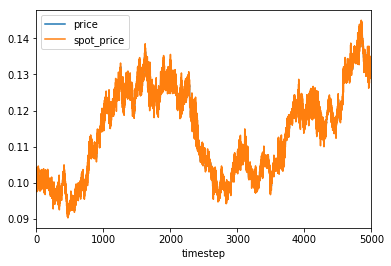

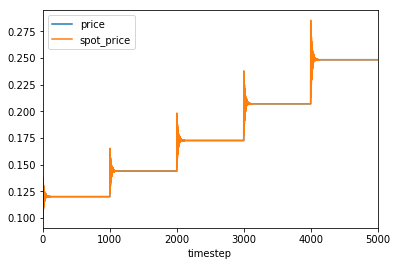

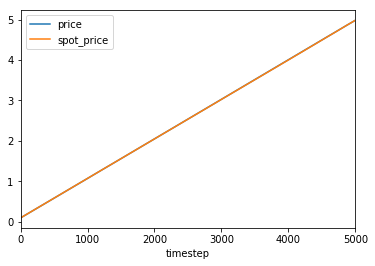

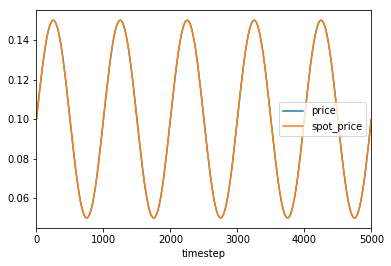

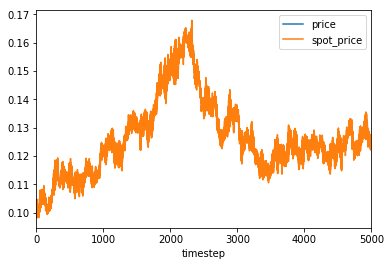

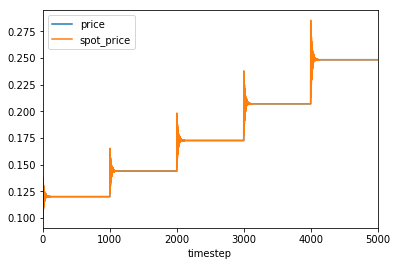

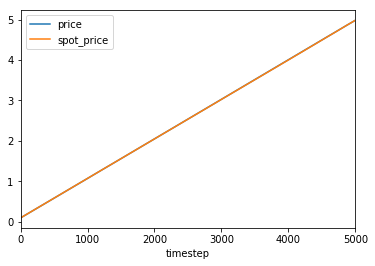

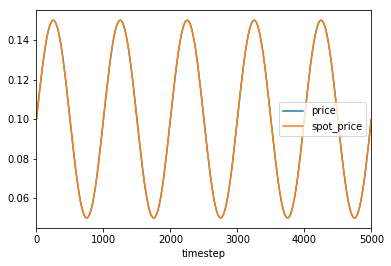

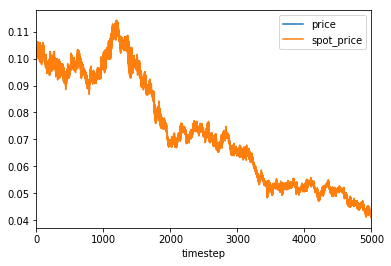

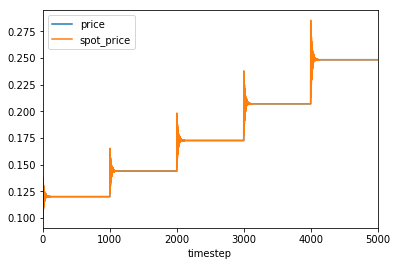

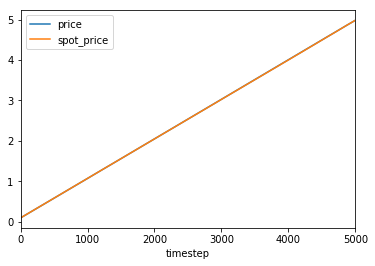

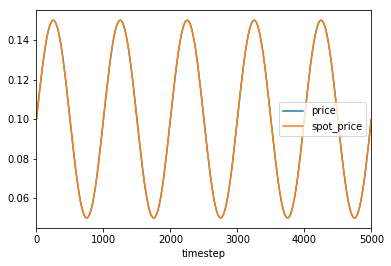

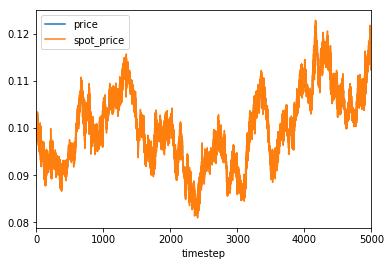

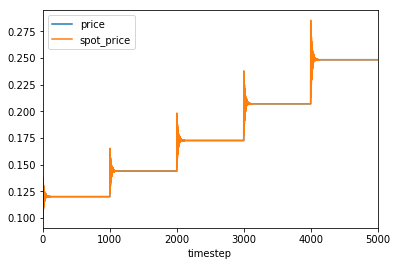

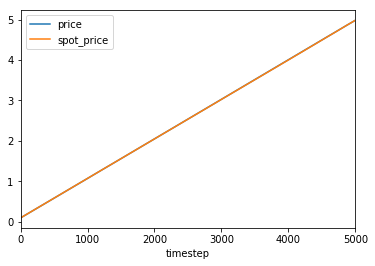

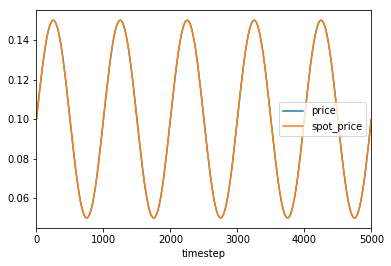

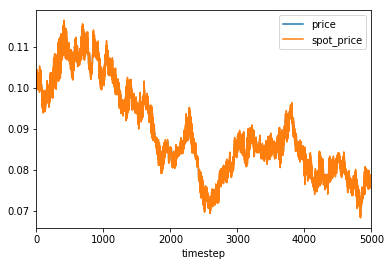

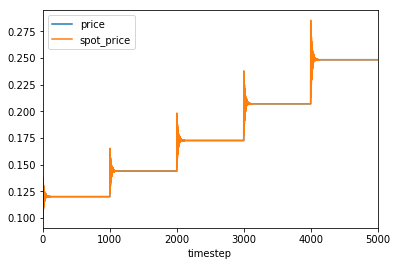

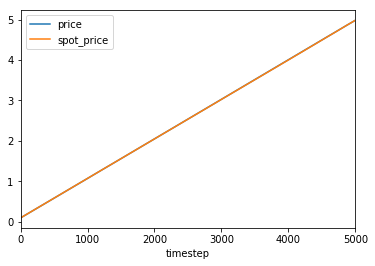

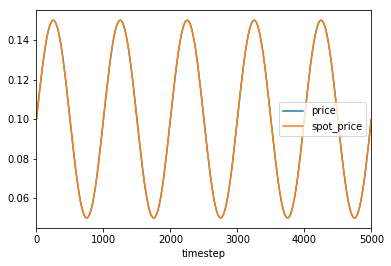

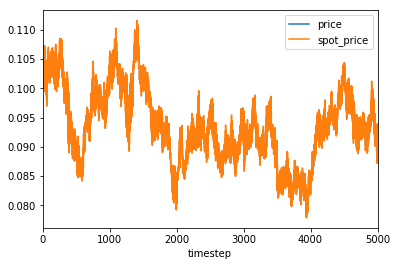

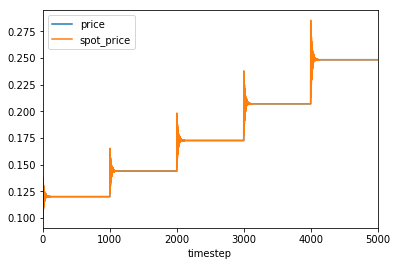

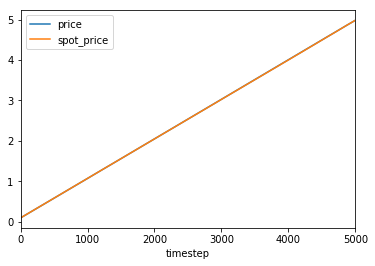

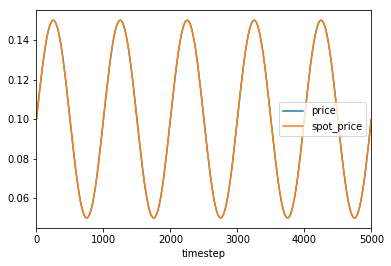

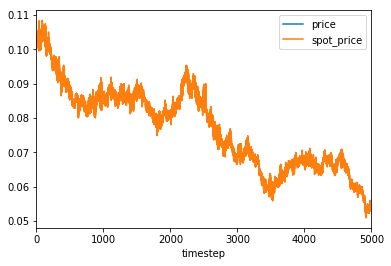

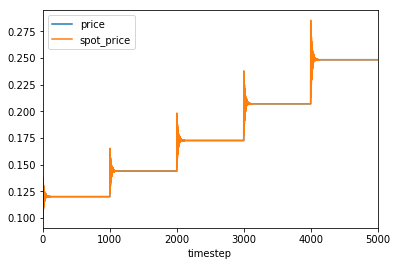

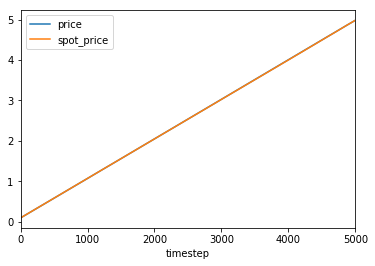

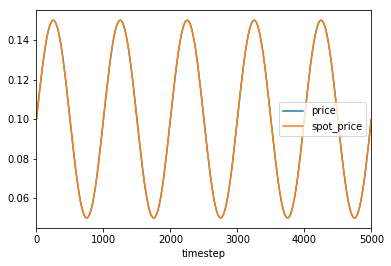

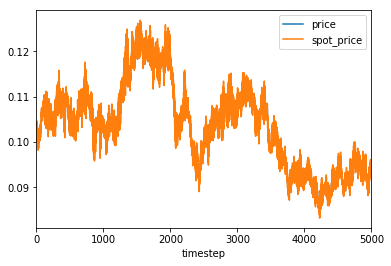

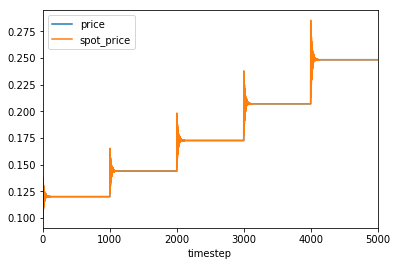

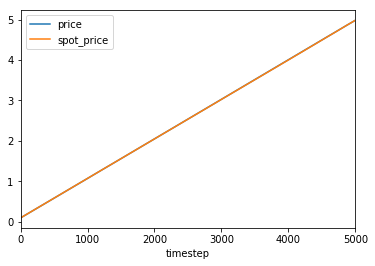

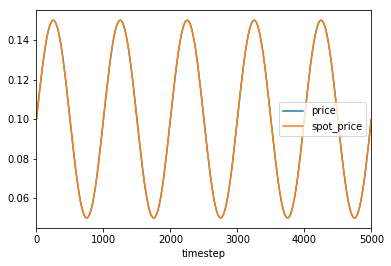

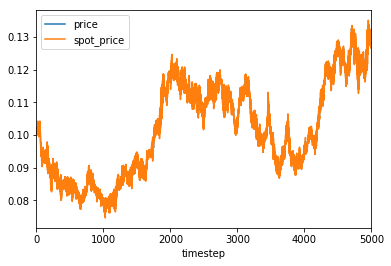

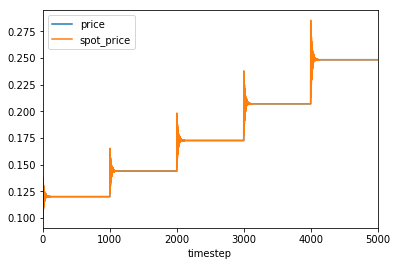

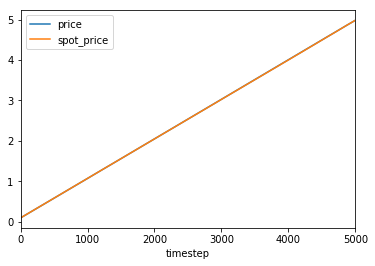

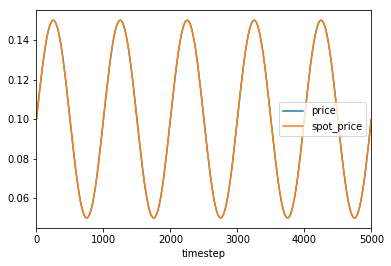

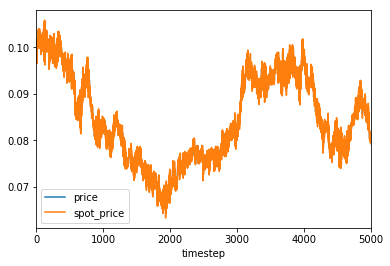

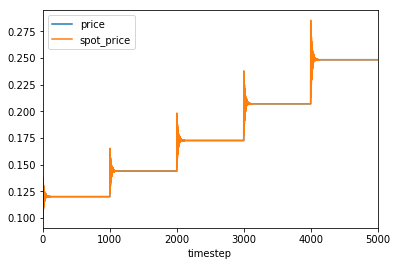

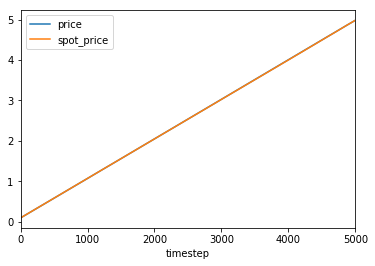

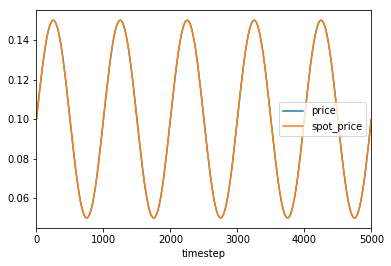

In [20]:
df[['timestep','experiment_index','run','price', 'spot_price']].groupby(['run','experiment_index']).plot(x='timestep', y=['price', 'spot_price'])

In [21]:
df['err'] = df.price-df.spot_price
df['abs_err']= df.err.apply(abs)

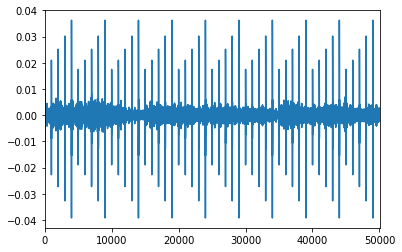

In [22]:
df.err.plot()

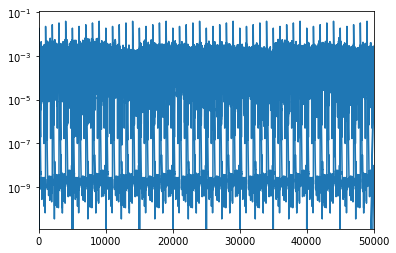

In [23]:
df.abs_err.plot(logy=True)


run  experiment_index
0    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
1    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
2    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125;0.775x0.755)
3    0                   AxesSubplot(0.125,0.125;0.775x0.755)
     1                   AxesSubplot(0.125,0.125;0.775x0.755)
     2                   AxesSubplot(0.125,0.125;0.775x0.755)
     3                   AxesSubplot(0.125,0.125

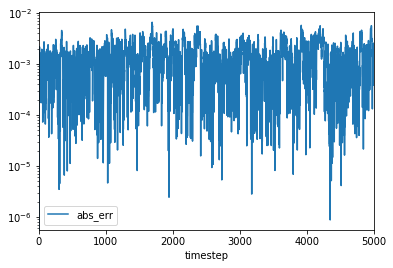

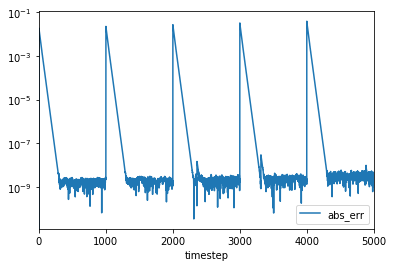

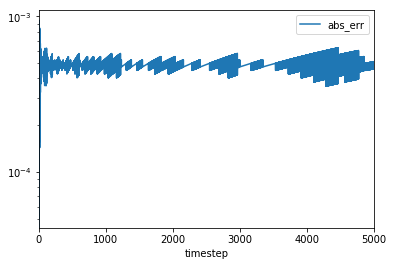

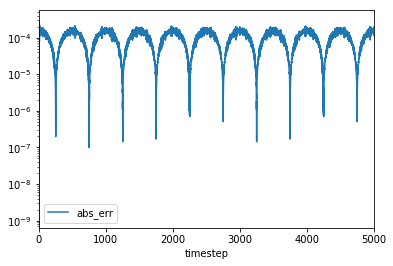

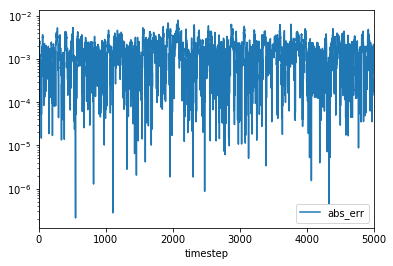

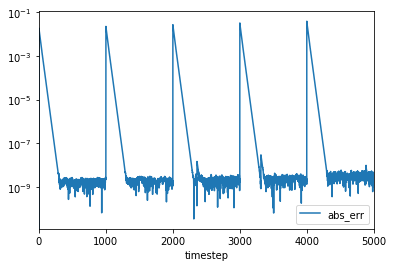

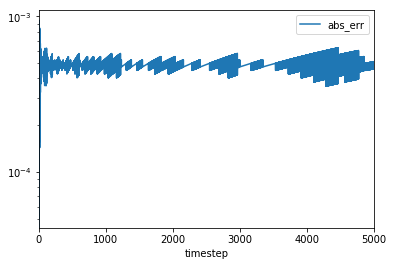

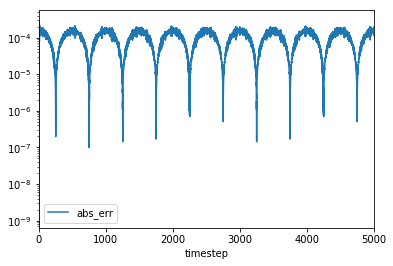

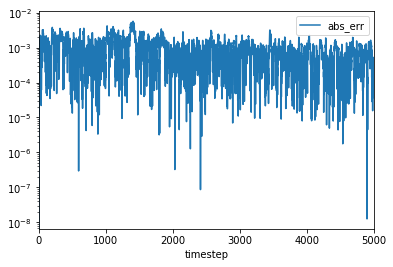

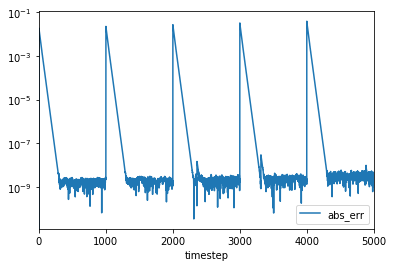

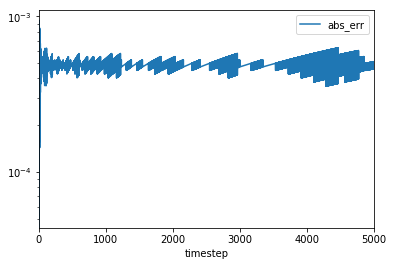

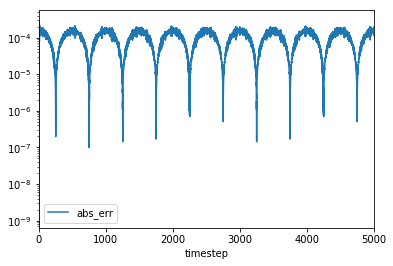

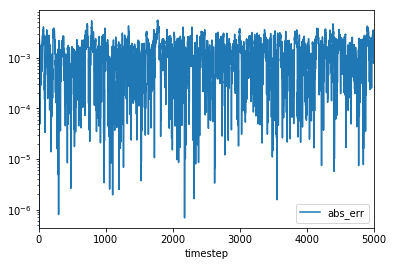

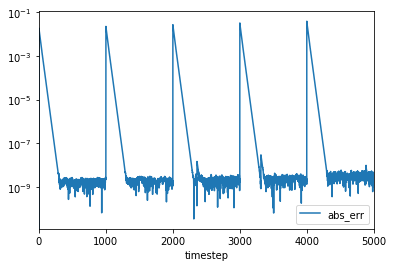

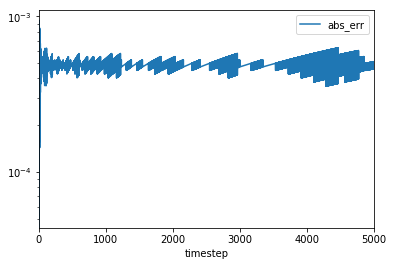

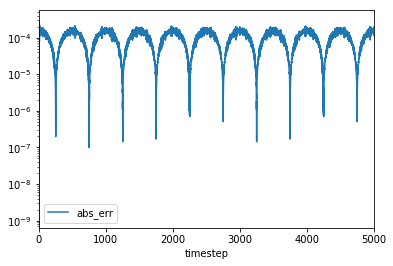

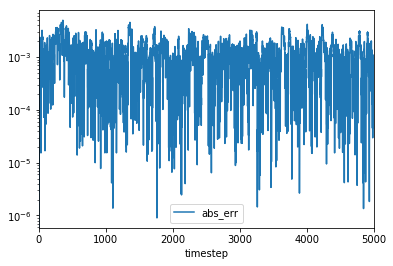

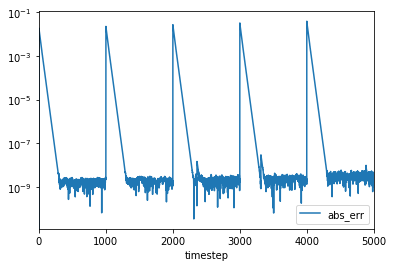

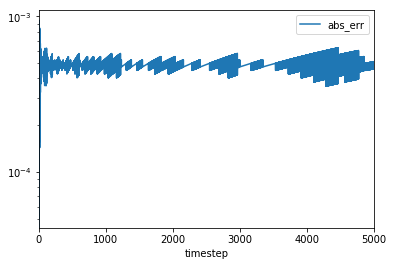

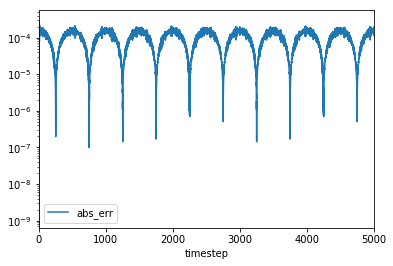

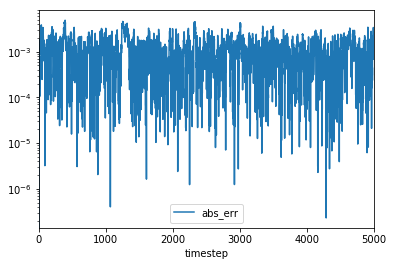

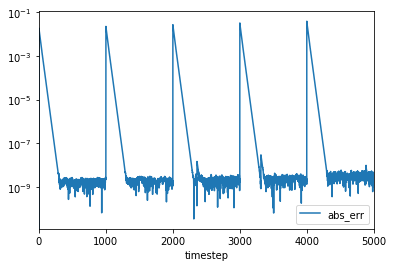

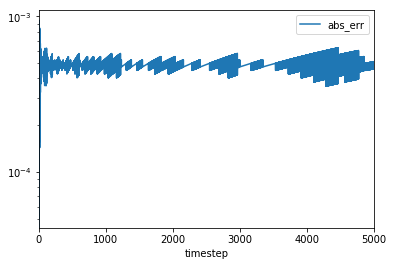

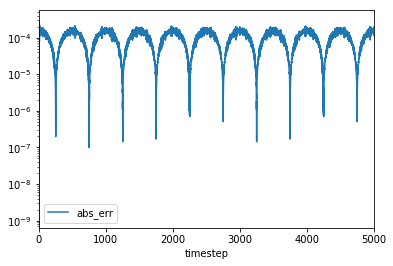

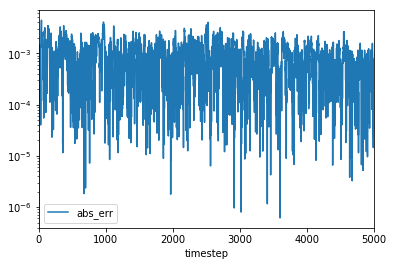

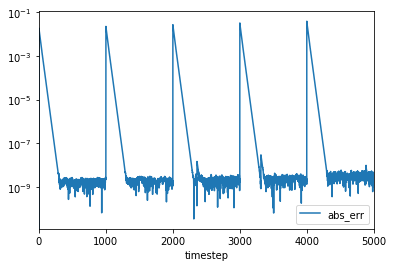

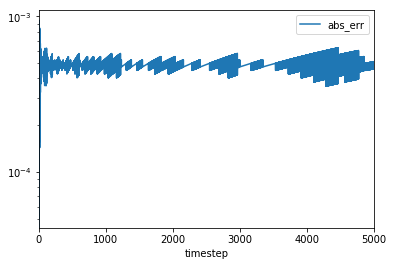

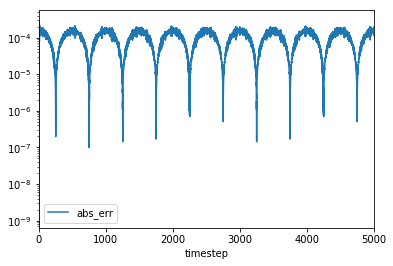

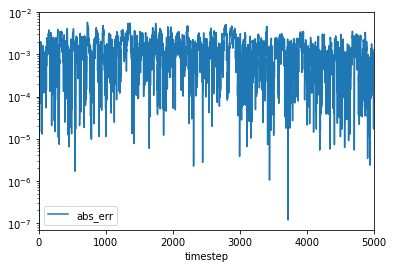

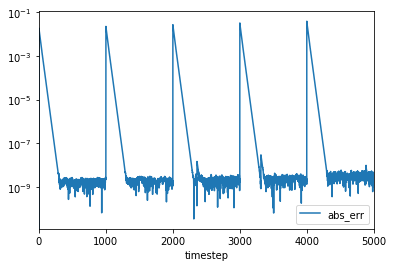

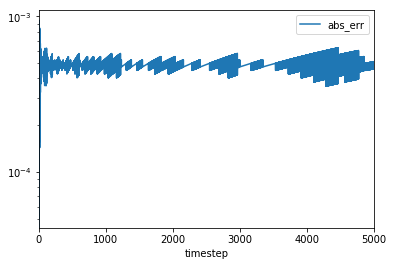

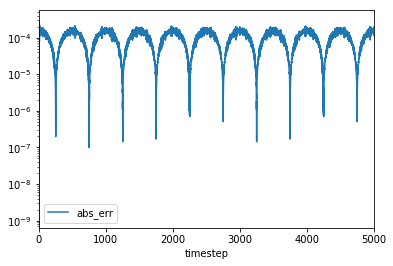

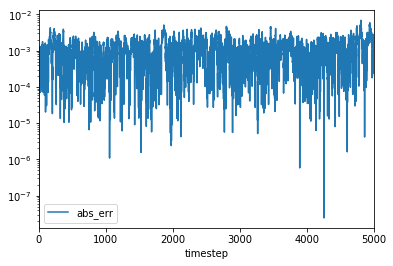

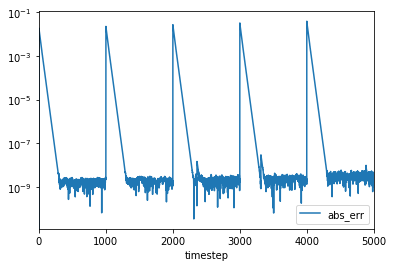

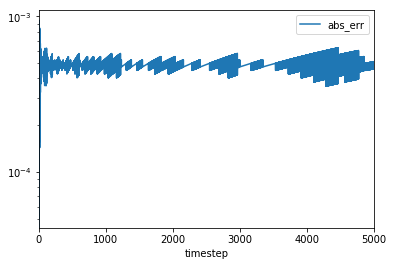

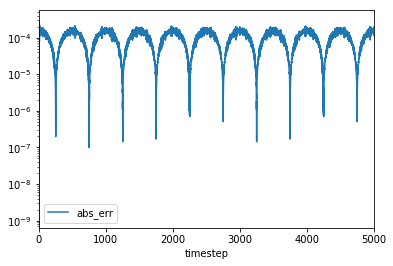

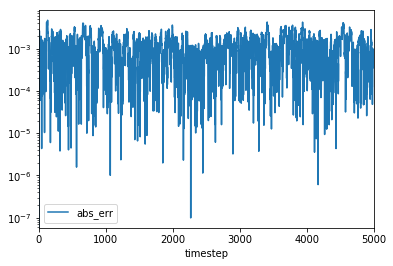

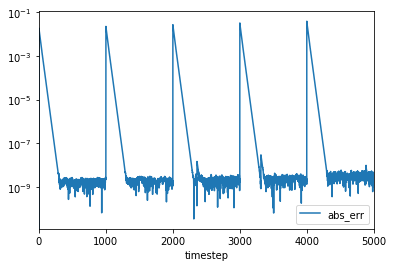

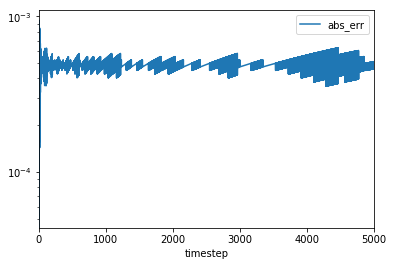

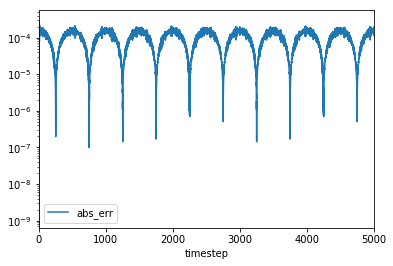

In [24]:
df[['timestep','experiment_index','run','abs_err']].groupby(['run','experiment_index']).plot(x='timestep', y='abs_err', logy=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


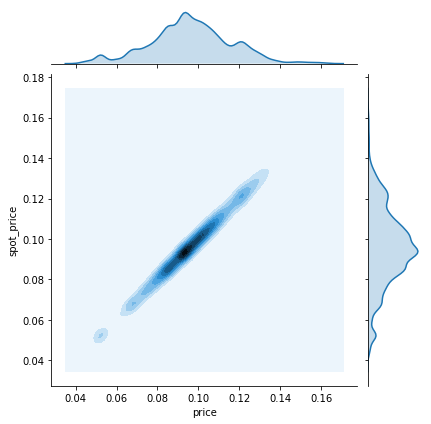

In [25]:
sns.jointplot(x='price', y='spot_price',kind='kde',data=df[df.rule=="martin"])

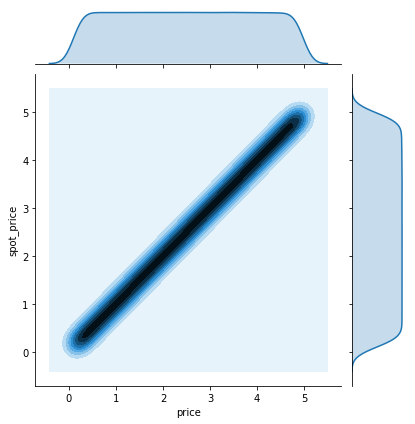

In [26]:
sns.jointplot(x='price', y='spot_price',kind='kde',data=df[df.rule=="ramp"])

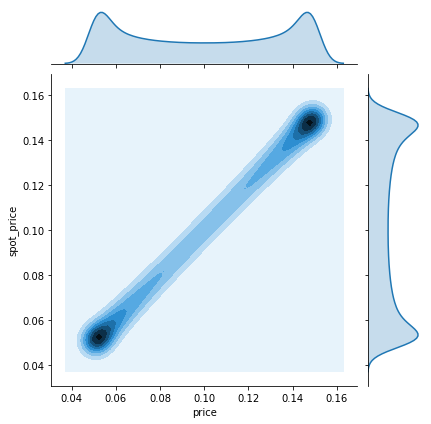

In [27]:
sns.jointplot(x='price', y='spot_price',kind='kde',data=df[df.rule=="sin"])

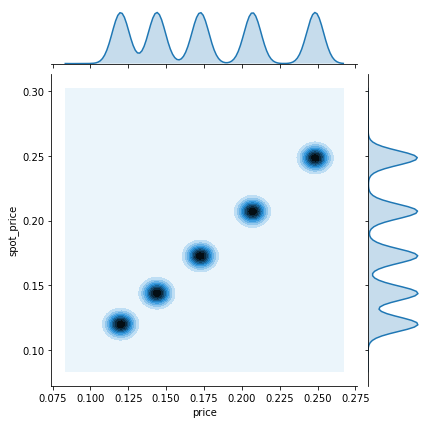

In [28]:
sns.jointplot(x='price', y='spot_price',kind='kde',data=df[df.rule=="step"])